# Comparative statics with respect to preference parameters 

In [1]:
import Pkg
Pkg.activate(joinpath(@__DIR__, ".."))
# Pkg.instantiate()

  Activating environment at `~/Documents/Github/micro_risks_pareto_improving_policies/Project.toml`


In [2]:
_FIGURES_DIR = joinpath(@__DIR__, "..", "output", "figures")

"/home/amador.manuel/Documents/Github/micro_risks_pareto_improving_policies/scripts/../output/figures"

In [3]:
using Revise
using UnPack
using Aiyagari
using StructArrays
using ProgressMeter
using DelimitedFiles
using Roots
using Plots
using LaTeXStrings
using PrettyTables
using FLoops

In [4]:
pgfplotsx();
Threads.nthreads()

16

In [5]:
ProgressMeter.ijulia_behavior(:clear);
default(label = "", lw = 2, dpi = 300, left_margin = 0Plots.mm, format=:svg);

In [6]:
function creating_economies(vals_list)
    e_vals = NamedTuple{(:ies, :crra, :β, :e),Tuple{Float64, Float64, Float64, Economy}}[]
    for vals in vals_list
        crra = vals.crra
        β = vals.β
        ies = vals.ies
        e = let
            #Household:
            ar1 = 0.9695
            sigmaP = sqrt(0.0384)/(1.2)
            sigmaIID = sqrt(0.0522)/(1.2)
            P, z_vals = calibration(5, 2 , ar1, sigmaP, sigmaIID)

            hh = Household(u = EZ(ies = ies, ra = crra), grid_points = 5_000,
                v = GHH(θ = 1.0, ν = 0.2), P = P, z_grid = z_vals, β = β, a_max = 10.0)

            #Technology
            δ = 0.1
            μ = 1.4
            α = .3
            #ρ = 0.7
            A_μ = 0.2
            # t_μ = MarkupTechnology(f = CES(α = α, ρ = 0.7), δ = δ, μ = μ, A = A_μ)
            t_μ = MarkupTechnology(f = CobbDouglas(α = α), δ = δ, μ = μ, A = A_μ)

            Economy(h = hh, t = t_μ)
        end
        push!(e_vals, (ies = ies, crra = crra, β = β, e = e))
    end
    return e_vals
end

creating_economies (generic function with 1 method)

In [7]:
ies_vals = (1.0, 0.5, 1.5)
crra_vals = (5.5, 2.0, 10.0)
β_vals = (0.993, 0.97, 0.98)

pars = [(ies = ies_vals[1], crra = crra_vals[1], β = β_vals[1])]
for ies in ies_vals[2:end]
    push!(pars, (ies = ies, crra = crra_vals[1], β = β_vals[1]))
end 
for crra in crra_vals[2:end]
    push!(pars, (ies = ies_vals[1], crra = crra, β = β_vals[1]))
end
for β in β_vals[2:end]
    push!(pars, (ies = ies_vals[1], crra = crra_vals[1], β = β))
end
e_vals = creating_economies(pars);

In [8]:
# Internal parameters for computations 
_TOLS = (value_function = 1e-10, distribution = 1e-13) # (value_function = 1e-10, distribution = 1e-13)
_ITERS = 100 # 100

# Transitions lengths
_T = 100  # period of adjustment
_H = 50   # stationary part

50

In [9]:
function clean_transition_val(val)
    @unpack e, ies, crra, β = val
    y0 = val.laissez_faire.y
    path_r = val.transition.path.r
    path_tr = val.transition.path.transfer
    return (ies = ies, crra = crra, β = β, y0 = y0, e = e, path_r = path_r, path_tr = path_tr)
end 


function solve_one_sim(e, i; T = _T,  H = _H, tols = _TOLS, iters = _ITERS)
    println("Simulation # $i started")

    # Solve laissez-faire economy
    laissez_faire = let r_range = (-0.04, -0.00)
        solve_laissez_faire(e; r_range = r_range, tol =  tols, verbose = false)
    end

    println("Finished laissez-faire for simulation # $i")

    # We target a debt of 60% percent of output
    b_target = laissez_faire.y * 0.60
    k_target = laissez_faire.k

    # Solve final SS
    final_eq = solve_new_stationary_equilibrium_given_k_b(
        laissez_faire, k_target, b_target;
        r_range = (laissez_faire.r - 0.01, laissez_faire.r + 0.01), tol = tols, verbose = false
    )
    println("Finished new eqm for simulation # $i")

    # Smooth debt policy
    ρB = 0.9
    b_list = Array{Float64,1}(undef, T + H)
    b_list[1] = 0.0
    b_list[2] = laissez_faire.y * 0.05
    b_list[T:end] .= b_target
    for j in 3:T-1
        b_list[j] = b_list[2] * ρB^(j-2) + (1 - ρB^(j-2)) * b_target
    end

    # k remains constant
    k_list = [laissez_faire.k for _ in b_list]

    # Computes the transition
    transition = solve_transition(
        laissez_faire,
        final_eq,
        k_list,
        b_list;
        init_r_path = nothing,
        iterations = iters,
        show_trace = false)
    
    println("Finished transition for simulation # $i, residual = $(maximum(abs.(transition.residuals)))")    

    return (e_vals[i]..., laissez_faire = laissez_faire, transition = transition)
end


function solve_all_sims(e_vals; tols = _TOLS, iters = _ITERS)
    #Iterate over preferences
    transitions = Array{Any}(undef, length(e_vals))

    for i in eachindex(e_vals)
        transitions[i] = solve_one_sim(e_vals[i].e, i, tols = tols, iters = iters) 
    end
    
    return [clean_transition_val(x) for x in transitions]
end 

solve_all_sims (generic function with 1 method)

In [10]:
@time out = solve_all_sims(e_vals);

Simulation # 1 started
Finished laissez-faire for simulation # 1
Finished new eqm for simulation # 1
Finished transition for simulation # 1, residual = 6.68164659067207e-5
Simulation # 2 started
Finished laissez-faire for simulation # 2
Finished new eqm for simulation # 2
Finished transition for simulation # 2, residual = 6.454395701899466e-5
Simulation # 3 started
Finished laissez-faire for simulation # 3
Finished new eqm for simulation # 3
Finished transition for simulation # 3, residual = 7.49896883163699e-5
Simulation # 4 started
Finished laissez-faire for simulation # 4
Finished new eqm for simulation # 4
Finished transition for simulation # 4, residual = 6.978104201346545e-5
Simulation # 5 started
Finished laissez-faire for simulation # 5
Finished new eqm for simulation # 5
Finished transition for simulation # 5, residual = 7.230931260856717e-5
Simulation # 6 started
Finished laissez-faire for simulation # 6
Finished new eqm for simulation # 6
Finished transition for simulation #

## Plots 

In [11]:
benchmark = let 
    benchmark_i = findfirst(x -> x.ies == ies_vals[1] && x.crra == crra_vals[1] && x.β == β_vals[1], out)
    out[benchmark_i]
end;

### IES

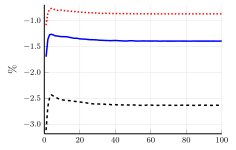

In [60]:
f1 = plot(100 .* benchmark.path_r,  linecolor=:blue, lw = 1.5, size = (1000/3, 500/2), ylabel = L"\%")
xlims!(f1, 0, 100)
plot!(f1, [100.0 * y.path_r for y in out if y.ies==0.5 && y.crra==5.5 && y.β==0.993], linecolor=:black, linestyle=:dash, lw = 1.5)
plot!(f1, [100.0 * y.path_r for y in out if y.ies==1.5 && y.crra==5.5 && y.β==0.993], linecolor=:red, linestyle=:dot, lw = 1.5)

In [61]:
savefig(f1, joinpath(_FIGURES_DIR, "IES_interest.pdf"))

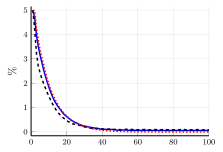

In [62]:
f2 = plot(100 * benchmark.path_tr./benchmark.y0,  linecolor=:blue, lw = 1.5,  size = (1000/3, 500/2), ylabel = L"\%")
xlims!(f2, 0, 100)
plot!(f2, [100 * y.path_tr / y.y0 for y in out if y.ies==0.5 && y.crra==5.5 && y.β==0.993], linecolor=:black, linestyle=:dash, lw = 1.5)
plot!(f2, [100 * y.path_tr / y.y0 for y in out if y.ies==1.5 && y.crra==5.5 && y.β==0.993], linecolor=:red, linestyle=:dot, lw = 1.5)

In [63]:
savefig(f2, joinpath(_FIGURES_DIR, "IES_transfers.pdf"))

### Discount

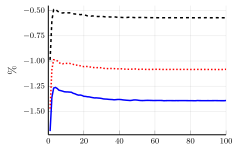

In [64]:
f3 = plot(100 .* benchmark.path_r,  linecolor=:blue, lw = 1.5, size = (1000/3, 500/2), ylabel = L"\%")
xlims!(f3, 0, 100)
plot!(f3, [100 * y.path_r for y in out if y.ies==1.0 && y.crra==5.5 && y.β==0.97], linecolor=:black, linestyle=:dash, lw = 1.5)
plot!(f3, [100 * y.path_r for y in out if y.ies==1.0 && y.crra==5.5 && y.β==0.98], linecolor=:red, linestyle=:dot, lw = 1.5)

In [65]:
savefig(f3, joinpath(_FIGURES_DIR, "Beta_interest.pdf"))

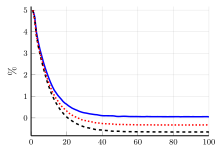

In [66]:
f4 = plot(100 .* benchmark.path_tr./benchmark.y0,  linecolor=:blue, lw = 1.5, size = (1000/3, 500/2), ylabel = L"\%")
xlims!(f4, 0, 100)
plot!(f4, [100 * y.path_tr / y.y0 for y in out if y.ies==1.0 && y.crra==5.5 && y.β==0.97], linecolor=:black, linestyle=:dash, lw = 1.5)
plot!(f4, [100 * y.path_tr / y.y0 for y in out if y.ies==1.0 && y.crra==5.5 && y.β==0.98], linecolor=:red, linestyle=:dot, lw = 1.5)

In [67]:
savefig(f4, joinpath(_FIGURES_DIR, "Beta_transfers.pdf"))

### CRRA

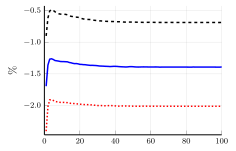

In [68]:
f5 = plot(100 .* benchmark.path_r,  linecolor=:blue, lw = 1.5, size = (1000/3, 500/2), ylabel = L"\%")
xlims!(f5, 0, 100)
plot!(f5, [100 * y.path_r for y in out if y.ies==1.0 && y.crra==2.0 && y.β==0.993], linecolor=:black, linestyle=:dash, lw = 1.5)
plot!(f5, [100 * y.path_r for y in out if y.ies==1.0 && y.crra==10.0 && y.β==0.993], linecolor=:red, linestyle=:dot, lw = 1.5)

In [69]:
savefig(f5, joinpath(_FIGURES_DIR, "CRRA_interest.pdf"))

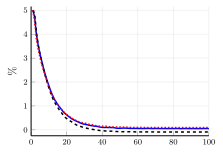

In [70]:
f6 = plot(100 .* benchmark.path_tr./benchmark.y0,  linecolor=:blue, lw = 1.5, size = (1000/3, 500/2), ylabel = L"\%")
xlims!(f6, 0, 100)
plot!(f6, [100 * y.path_tr/y.y0 for y in out if y.ies==1.0 && y.crra==2.0 && y.β==0.993], linecolor=:black, linestyle=:dash, lw = 1.5)
plot!(f6, [100 * y.path_tr/y.y0 for y in out if y.ies==1.0 && y.crra==10.0 && y.β==0.993], linecolor=:red, linestyle=:dot, lw = 1.5)

In [71]:
savefig(f6, joinpath(_FIGURES_DIR, "CRRA_transfers.pdf"))

## Tables

In [72]:
rates = []
push!(rates,(Elasticity="Benchmark", Initial=benchmark.path_r[1],Final=benchmark.path_r[end],Max=maximum(benchmark.path_r)))
push!(rates,
    (Elasticity="Inelastic", Initial=[y.path_r for y in out if y.ies==0.5 && y.crra==5.5 && y.β==0.993][1][1],
    Final=[y.path_r for y in out if y.ies==0.5 && y.crra==5.5 && y.β==0.993][1][end], 
    Max=maximum([y.path_r for y in out if y.ies==0.5 && y.crra==5.5 && y.β==0.993][1])
    )
)
push!(rates,
    (Elasticity="Elastic", Initial=[y.path_r for y in out if y.ies==1.5 && y.crra==5.5 && y.β==0.993][1][1],
    Final=[y.path_r for y in out if y.ies==1.5 && y.crra==5.5 && y.β==0.993][1][end], 
    Max=maximum([y.path_r for y in out if y.ies==1.5 && y.crra==5.5 && y.β==0.993][1])
    )
)

transfers = []
push!(transfers,(Elasticity="Benchmark", y0=benchmark.y0, Initial=benchmark.path_tr[1],Final=benchmark.path_tr[end],Min=minimum(benchmark.path_tr)))
push!(transfers,
    (Elasticity="Inelastic", y0=[y.y0 for y in out if y.ies==0.5 && y.crra==5.5 && y.β==0.993][1], Initial=[y.path_tr./y.y0 for y in out if y.ies==0.5 && y.crra==5.5 && y.β==0.993][1][1],
    Final=[y.path_tr./y.y0 for y in out if y.ies==0.5 && y.crra==5.5 && y.β==0.993][1][end], 
    Min=minimum([y.path_tr./y.y0 for y in out if y.ies==0.5 && y.crra==5.5 && y.β==0.993][1])
    )
)
push!(transfers,
    (Elasticity="Elastic", y0=[y.y0 for y in out if y.ies==1.5 && y.crra==5.5 && y.β==0.993][1], Initial=[y.path_tr./y.y0 for y in out if y.ies==1.5 && y.crra==5.5 && y.β==0.993][1][1],
    Final=[y.path_tr./y.y0 for y in out if y.ies==1.5 && y.crra==5.5 && y.β==0.993][1][end], 
    Min=minimum([y.path_tr./y.y0 for y in out if y.ies==1.5 && y.crra==5.5 && y.β==0.993][1])
    )
);

In [73]:
pretty_table([y for y in rates])

┌────────────┬────────────┬─────────────┬─────────────┐
│ Elasticity │    Initial │       Final │         Max │
│     String │    Float64 │     Float64 │     Float64 │
├────────────┼────────────┼─────────────┼─────────────┤
│  Benchmark │ -0.0169517 │  -0.0139586 │  -0.0126181 │
│  Inelastic │   -0.03113 │  -0.0263426 │  -0.0243275 │
│    Elastic │  -0.010861 │ -0.00869329 │ -0.00761818 │
└────────────┴────────────┴─────────────┴─────────────┘


In [74]:
pretty_table([y for y in transfers])

┌────────────┬──────────┬───────────┬─────────────┬──────────────┐
│ Elasticity │       y0 │   Initial │       Final │          Min │
│     String │  Float64 │   Float64 │     Float64 │      Float64 │
├────────────┼──────────┼───────────┼─────────────┼──────────────┤
│  Benchmark │ 0.216899 │ 0.0108449 │ 0.000142094 │  0.000108729 │
│  Inelastic │ 0.238819 │  0.050002 │ 0.000910436 │  0.000721934 │
│    Elastic │ 0.209146 │ 0.0499999 │  5.93696e-6 │ -0.000102102 │
└────────────┴──────────┴───────────┴─────────────┴──────────────┘
